# PROJECT 1 - PART 1

## 0 - imports

In [697]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
import shap
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## 1 - Q1 Exploratory Data Analysis

### 1.1 - loading data

In [698]:
df_train = pd.read_csv("datasets/heart_failure/train_val_split.csv")
df_test = pd.read_csv("datasets/heart_failure/test_split.csv")

#### NOTES AND OBSERVATIONS:
- AGE = age of the subjects, (29,77), peak 55 ca
- SEX = gender of the patient, M/F, mostly males
- CHEST PAIN TYPE = type of chest pain experienced by the patient, (ATA, ASY, NAP, TA), mostly ASY
--------------------------------------------------------------------------
med note: 
- ATA (Typical Angina):type of chest pain typically occurs when the heart is working harder than usual, considered a classic symptom of coronary artery disease (CAD)
- ASY (Atypical Angina): chest pain that doesn't fit the typical pattern of typical angina, still indicate underlying heart problems
- NAP (Non-Anginal Pain): chest discomfort or pain that is not related to angina or heart-related issues, not directly related to coronary artery disease
- TA (Asymptomatic): patient does not experience any chest pain
--------------------------------------------------------------------------
- RESTING BP = resting blood pressure of the patient, (should be under 120), however most of the data is above 120 -> higher RBP = increased risk of CHD, peaks (120,130,140)
- CHOLESTEROL = cholesterol level of the patient, (0,530), high cholesterol is a major risk factor for CHD, IDK ABOUT VALUES
- FASTING BS = amount of glucose in the bloodstream after fasting for at least 8 hours, (0 if <120 mg/dl, 1 if> 120 mg/dl), if 1 -> significant risk factor for CHD
- RESTING ECG = electrical activity of the heart while the patient is at rest, (normal, ST, LVH), ST segment changes = indicate risk of CHD
- MAX HR = maximum heart rate achieved by the patient, (60, 195), abnormal responses may indicate underlying heart disease, IDK ABOUT VALUES
- EXERCISE ANGINA = chest pain that occurs during physical activity, (N,Y), angina is a common symptom of CHD
- OLD PEAK = ST depression induced by exercise relative to rest, (-2, 6.2), ST depression during exercise stress testing is a common finding in patients with CHD, IDK ABOUT VALUES
- ST SLOPE = direction and angle of the ST segment on an electrocardiogram, (Up, Flat, Down), down ST slope is associated with CHD
- HEART DISEASE = blood vessel diameter narrowing, (0 = < 50%, 1 = > 50%), 1 = CHD

### 1.2 - dataset exploration

In [699]:
# 0 - dimensions
print(f"Number of samples: {df_train.shape[0]:,.0f}")
print(f"Number of features: {df_train.shape[1]}")
print("--------------------------------------------------------------------------------")

# 1 - general info
df_train.info()
print("--------------------------------------------------------------------------------")

# 2 - look at some samples
df_train.head(5)

Number of samples: 734
Number of features: 12
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB
---------------------------------------------------------------------------

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


#### REPORT:
We notice that:
- the dataset is quite small
- we don't have null values
- we have two types of features: categorical and numerical features

### 1.3 - numerical features

In [700]:
# 0 - general informations
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,734.0,53.523161,9.421110,29.0,47.00,54.0,60.0,77.0
RestingBP,734.0,132.062670,18.618490,0.0,120.00,130.0,140.0,200.0
Cholesterol,734.0,197.588556,108.979439,0.0,172.25,222.0,267.0,529.0
FastingBS,734.0,0.232970,0.423012,0.0,0.00,0.0,0.0,1.0
MaxHR,734.0,136.167575,25.334552,60.0,120.00,138.0,155.0,195.0
Oldpeak,734.0,0.873978,1.082222,-2.0,0.00,0.5,1.5,6.2
HeartDisease,734.0,0.542234,0.498553,0.0,0.00,1.0,1.0,1.0


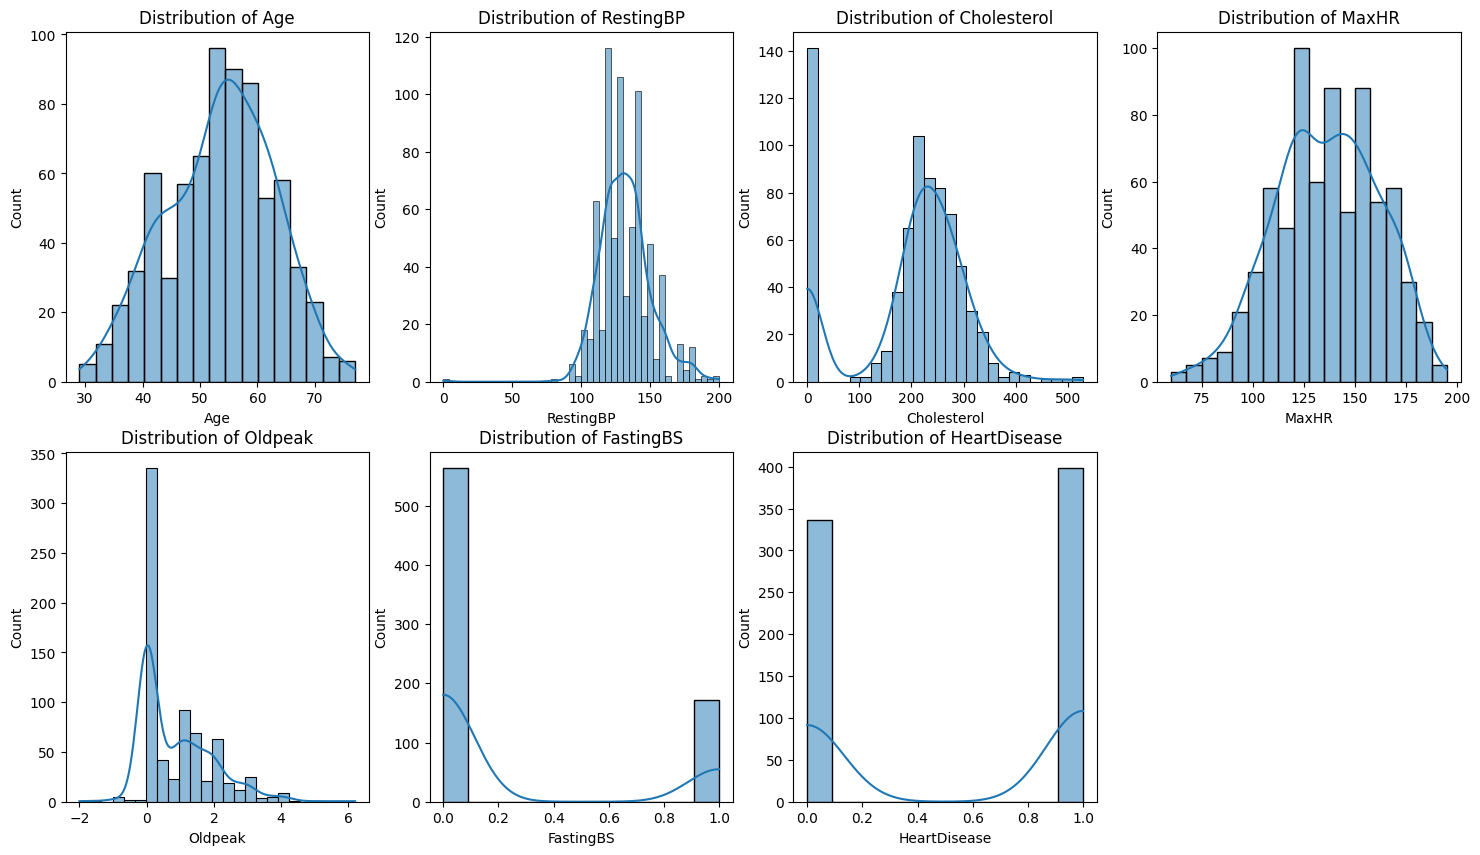

In [701]:
# 1 - data distributions
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
numerical_features = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak', 'FastingBS', 'HeartDisease']
for i, feature in enumerate(numerical_features, start=0):
    sb.histplot(data=df_train, x=feature, ax=axes[i // 4, i % 4], kde=True)
    axes[i // 4, i % 4].set_title(f'Distribution of {feature}')
fig.delaxes(axes[1, 3])

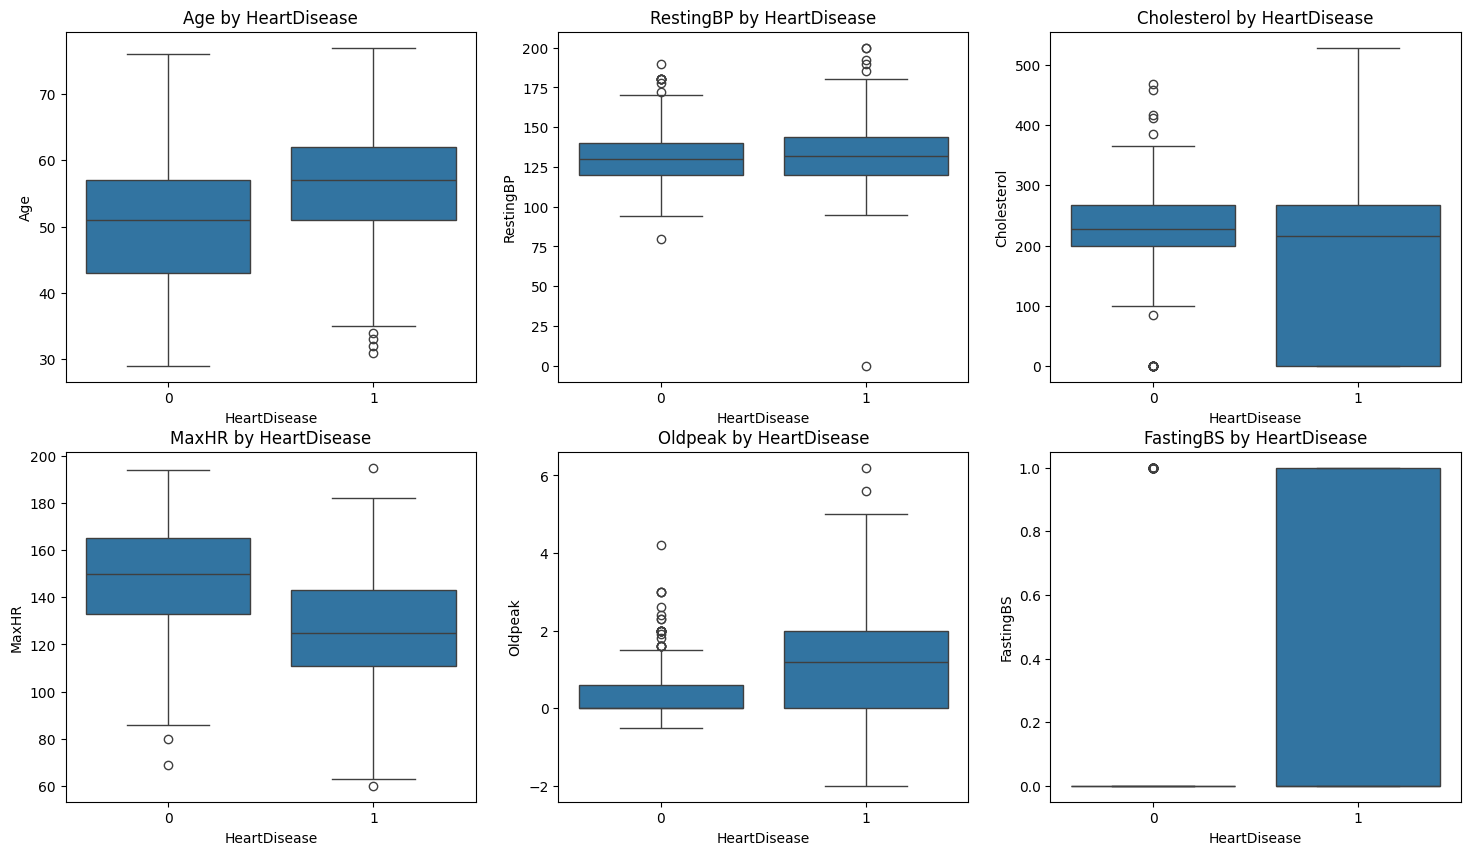

In [702]:
# 2 - features' relationship with heart disease
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak', 'FastingBS']
for i, feature in enumerate(features, start=0):
    sb.boxplot(data=df_train, x='HeartDisease', y=feature, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'{feature} by HeartDisease')

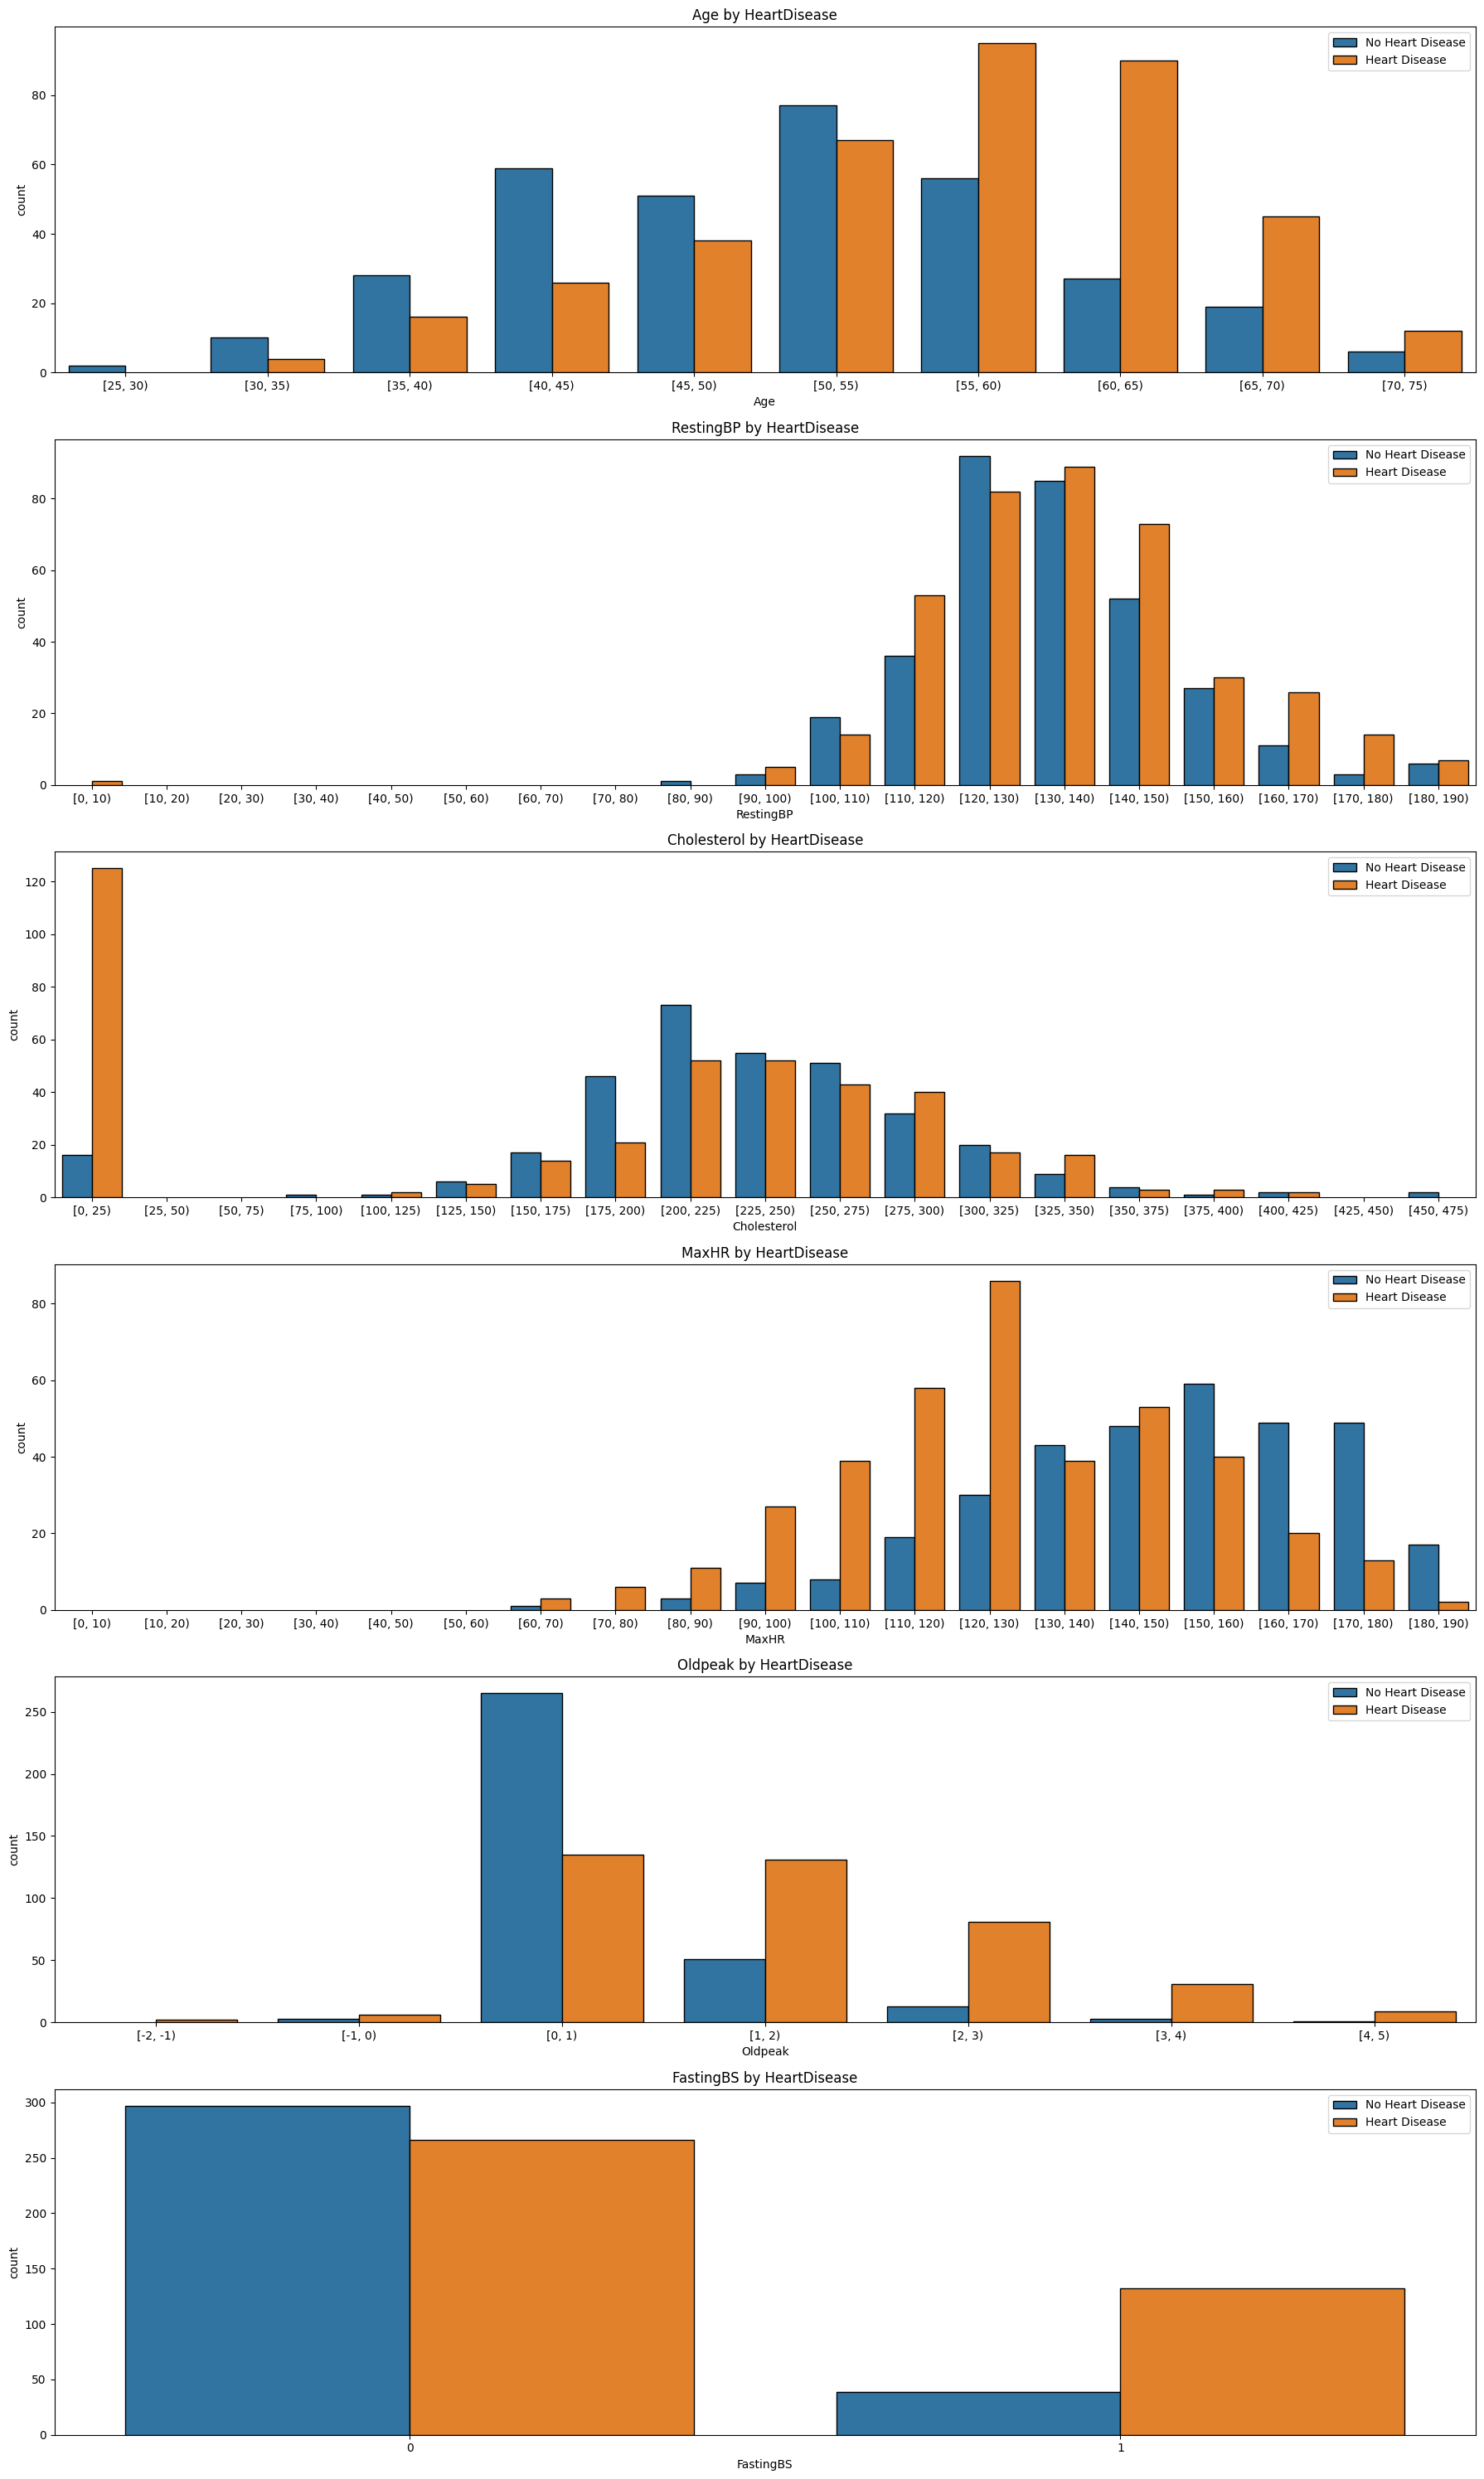

In [703]:
# 3 - features' relationship with heart disease (MORE READABLE)
data = pd.read_csv("datasets/heart_failure/train_val_split.csv")

for col in data.select_dtypes(include=['int64', 'float64']).columns:
    if col=='Age':
        data[col] = pd.cut(data[col], bins=range(25, 80, 5), right=False)
    if col=='RestingBP' or col=='MaxHR':
        data[col] = pd.cut(data[col], bins=range(0, 200, 10), right=False)
    if col=='Cholesterol':
        data[col] = pd.cut(data[col], bins=range(0, 500, 25), right=False)
    if col=='Oldpeak':
        data[col] = pd.cut(data[col], bins=range(-2, 6, 1), right=False)

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(18, 30))
for i, feature in enumerate(features, start=0):
    row = i % 6
    sb.countplot(x=feature, data=data, hue='HeartDisease', edgecolor='black', ax=axes[row])
    axes[row].legend(['No Heart Disease', 'Heart Disease'])
    axes[row].set_title(f'{feature} by HeartDisease')
plt.tight_layout()
plt.show()

#### REPORT:
- AGE = almost symmetric ≈ gaussian
- RESTINGBP = from the boxplot we can see outliers at 0
- CHOLESTEROL = almost symmetric ≈ gaussian but outliers at 0???? or bimodal??
- MAXHR = nothing to say
- OLDPEAK = value -2??, what is happening at 0??, skewed distribution
- FATSINGBS = from the boxplot it appears very related to the heart disease

### 1.4 - categorical features

In [704]:
# 0 - general informations
df_train.describe(include="object").T

,count,unique,top,freq
Sex,734,2,M,573
ChestPainType,734,4,ASY,381
RestingECG,734,3,Normal,440
ExerciseAngina,734,2,N,439
ST_Slope,734,3,Flat,364


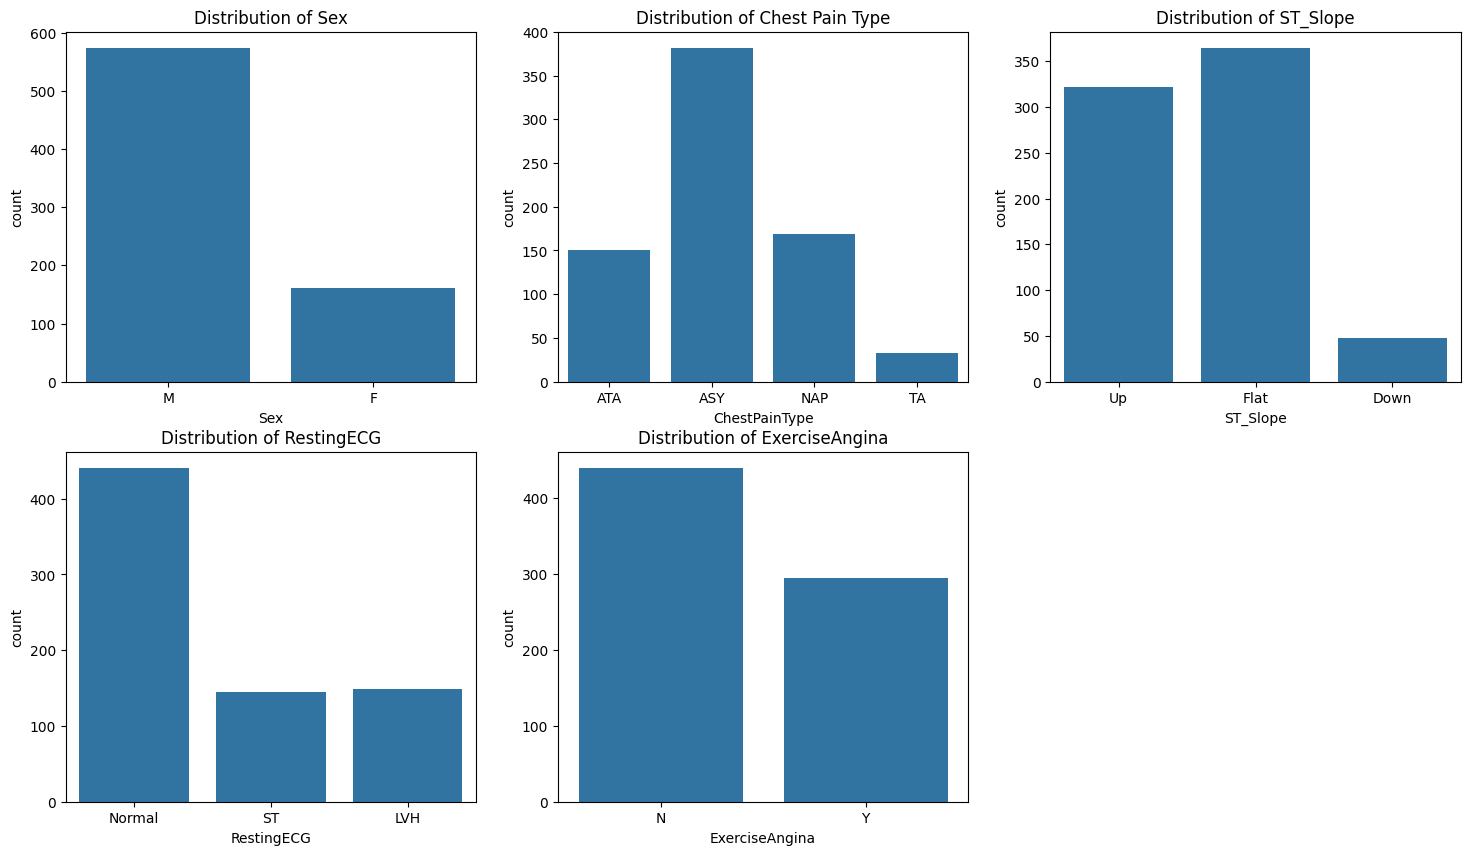

In [705]:
# 1 - feature distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# categorical features
sb.countplot(data=df_train, x='Sex', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Sex')
sb.countplot(data=df_train, x='ChestPainType', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Chest Pain Type')
sb.countplot(data=df_train, x='RestingECG', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of RestingECG')
sb.countplot(data=df_train, x='ExerciseAngina', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of ExerciseAngina')
sb.countplot(data=df_train, x='ST_Slope', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of ST_Slope')
fig.delaxes(axes[1, 2])

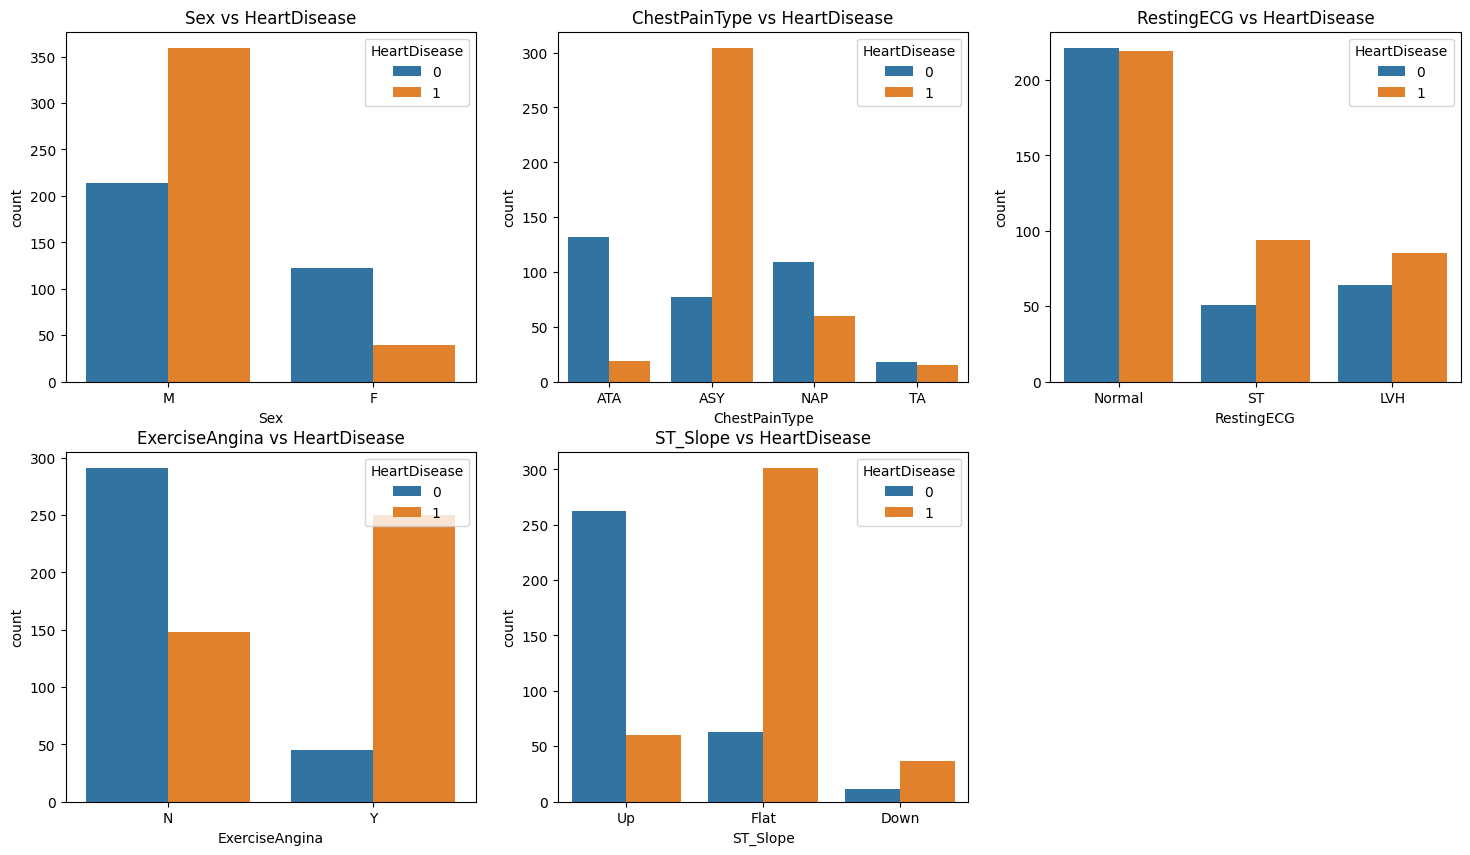

In [706]:
# 2 - features' relationship with heartdisease
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# categorical features
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for i, feature in enumerate(categorical_features, start=0):
    sb.countplot(data=df_train, x=feature, hue='HeartDisease', ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'{feature} vs HeartDisease')
    axes[i // 3, i % 3].legend(title='HeartDisease', loc='upper right')
fig.delaxes(axes[1, 2])

#### REPORT:
- SEX = more male patients (80%), males are more likely to have heart diseases
- CHESTPAINTYPE = ASY most common chest pain type (54%), ASY most likely to have heart diseases
- RESINGECG = normal ECG does not tell much about heart diseases (50% heart disease or not) while anomalies in ECG means that more likely heart disease
- EXERCISEANGINA = from the plot it seems very correlated with heart diseases
- ST_SLOPE = having flat/down ST_SLOPE appears to be very correlated with heart diseases



ALL CATEGORICAL FEATURES ARE NEARLY NORMALLY DISTRIBUTED

### 1.5 - check for null values

In [707]:
#number of null values for each feature
df_train.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

#### REPORT:
- no null values, clean dataset 

### 1.6 - dataset balance

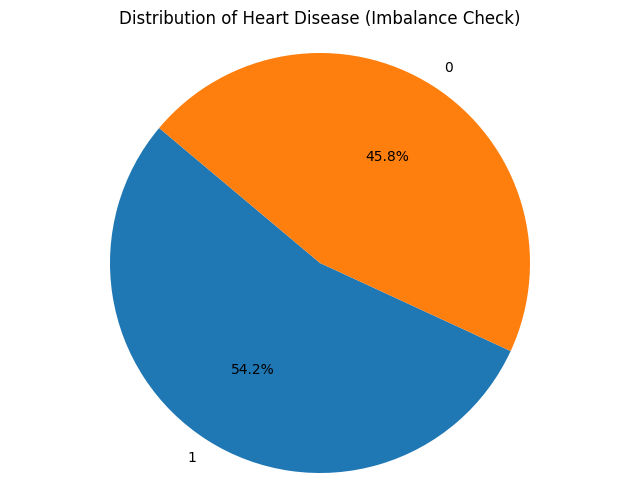

In [708]:
heart_disease_counts = df_train['HeartDisease'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(heart_disease_counts, labels=heart_disease_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Heart Disease (Imbalance Check)')
plt.axis('equal')
plt.show()

#### REPORT:
- The dataset is pretty much evenly balanced

### 1.7 - categorical data encoding

In [709]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoder = LabelEncoder()
for col in categorical_features:
    df_train[col]=label_encoder.fit_transform(df_train[col])
    df_test[col]=label_encoder.transform(df_test[col])

#### REPORT:
categorical data are encoded into numerical values for visualization & modeling purposes

### 1.8 - data preprocessing

In [710]:
mms = MinMaxScaler()
ss = StandardScaler()
rs = RobustScaler()

df_train['Oldpeak'] = mms.fit_transform(df_train[['Oldpeak']])
df_test['Oldpeak'] = mms.transform(df_test[['Oldpeak']])

df_train['Age'] = ss.fit_transform(df_train[['Age']])
df_test['Age'] = ss.transform(df_test[['Age']])

df_train['RestingBP'] = ss.fit_transform(df_train[['RestingBP']])
df_test['RestingBP'] = ss.transform(df_test[['RestingBP']])

df_train['Cholesterol'] = rs.fit_transform(df_train[['Cholesterol']])
df_test['Cholesterol'] = rs.transform(df_test[['Cholesterol']])

df_train['MaxHR'] = ss.fit_transform(df_train[['MaxHR']])
df_test['MaxHR'] = ss.fit_transform(df_test[['MaxHR']])

#### REPORT:
We have 2 options for data scaling : 1) Normalization 2) Standardization. As most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.
Normalization : Oldpeak feature is normalized as it had displayed a right skewed data distribution
Standardizarion : Age, RestingBP, Cholesterol and MaxHR features are scaled down because these features are normally distributed.

### 1.9 - features correltion with target

ST_Slope          0.568581
ExerciseAngina    0.502205
Oldpeak           0.420891
MaxHR             0.405552
ChestPainType     0.390924
Sex               0.319183
Age               0.294751
FastingBS         0.254086
Cholesterol       0.253538
RestingBP         0.101420
RestingECG        0.048260
Name: HeartDisease, dtype: float64


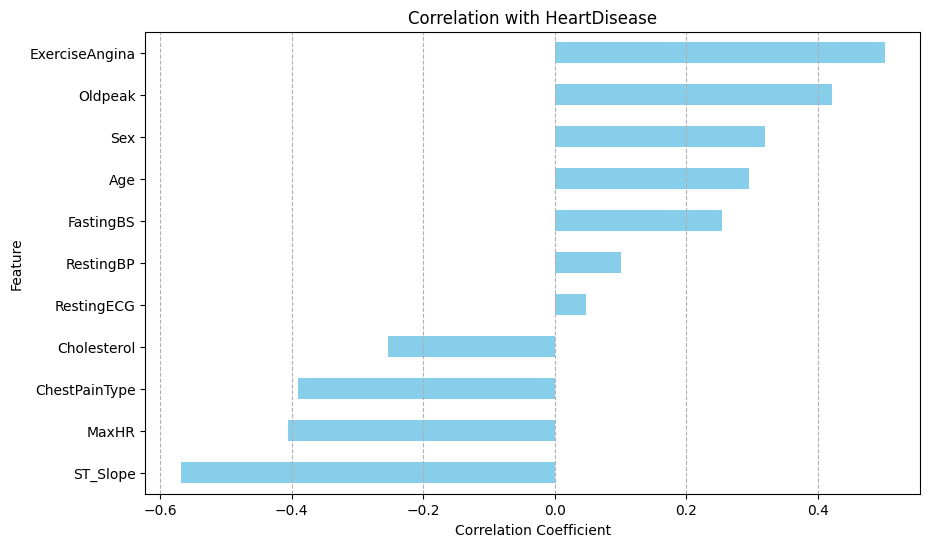

In [711]:
correlation = df_train.corr()['HeartDisease'].drop('HeartDisease')
abs_correlation = correlation.abs().sort_values(ascending=False)
print(abs_correlation)
# plot version
plt.figure(figsize=(10, 6))
correlation.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation with HeartDisease')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.show()

#### REPORT:
Except for RestingBP and RestingECG, everyone displays a positive or negative relationship with HeartDisease

sanity check:
- correlation coefficient close to 1 (either positive or negative) indicates a strong linear relationship between the two variables
- correlation coefficient close to 0 suggests little to no linear relationship between the two variables
- positive correlation coefficient indicates that as the feature increases, the target variable tends to increase as well
- negative correlation coefficient indicates that as the feature increases, the target variable tends to decrease
-------------------------------------------------------------------------------------------------------------------------------------
features correlation coefficient analysis:
- AGE: moderate positive correlation with 'HeartDisease' (0.29)
- SEX: moderate positive correlation with 'HeartDisease' (0.32)
- CHEST PAIN TYPE: moderate negative correlation with 'HeartDisease' (-0.39)
- RESTING BP: weak positive correlation with 'HeartDisease' (0.10)
- CHOLESTEROL: weak negative correlation with 'HeartDisease' (-0.25)
- FASTING BS: weak positive correlation with 'HeartDisease' (0.25)
- RESTING ECG: very weak positive correlation with 'HeartDisease' (0.05)
- MAX HR: moderate negative correlation with 'HeartDisease' (-0.41)
- EXERCISE ANGINA: strong positive correlation with 'HeartDisease' (0.50)
- OLD PEAK: moderate positive correlation with 'HeartDisease' (0.42)
- ST SLOPE: strong negative correlation with 'HeartDisease' (-0.57)
-------------------------------------------------------------------------------------------------------------------------------------
#### most related features:
- ST_Slope          0.568581
- ExerciseAngina    0.502205
- Oldpeak           0.420891
- MaxHR             0.405552
- ChestPainType     0.390924
-------------------------------------------------------------------------------------------------------------------------------------
#### less related features:
- RestingECG        0.048260
- RestingBP         0.101420
- Cholesterol       0.253538
- FastingBS         0.254086
- Age               0.294751


#### DOUBTS
- theory says that downwards ST slope should be correlated with CHD -> instead from our data flat appears to be correlated --> why?
- sex is really a good feature or is the experiment biased?
- as matteo pointed out some features have values 0 which do not make sense -> we should exclude those

## 2 - Q2 Lasso regression

#### 2.1 - dataset splitting

In [712]:
# split dataset
X_train = df_train.drop(columns=['HeartDisease'])
y_train = df_train['HeartDisease']
X_test = df_test.drop(columns=['HeartDisease'])
y_test = df_test['HeartDisease']

### 2.2 - lasso regression

In [713]:
# 0 - find best alpha with cross validation
lasso_cv = LassoCV(cv=7)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_
print('best alpha = ', best_alpha)

# 1 - fit
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

train_score = lasso.score(X_train, y_train)
test_score = lasso.score(X_test, y_test)

print("train R^2 Score:", train_score)
print("test R^2 Score:", test_score)

# 2 - move prediction to 0,1
y_pred = lasso.predict(X_test)
binary_predictions = np.where(y_pred >= 0.5, 1, 0)

# 3 - compute F1-score
f1 = f1_score(y_test, binary_predictions)
print("F1-score:", f1)

best alpha =  0.00020205117951440908
train R^2 Score: 0.5327635229079208
test R^2 Score: 0.42451072137407997
F1-score: 0.8699551569506726


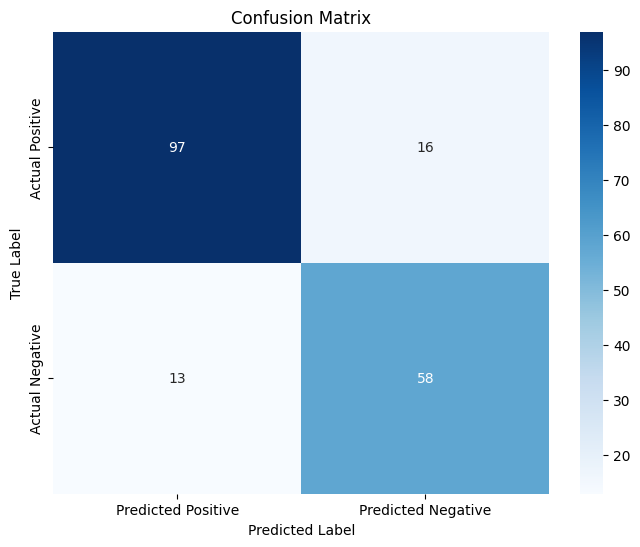

In [714]:
# f1 score visualization
tn, fp, fn, tp = confusion_matrix(y_test, binary_predictions).ravel()

conf_matrix = np.array([[tp, fp],
                        [fn, tn]])
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### REPORT:
Find Best Alpha with Cross Validation
- Use LassoCV to find the best alpha value for Lasso regression using 7-fold cross-validation
Fit Lasso Regression Model
- Fit a Lasso regression model with the best alpha value found in the previous step to the training data
Evaluate Model Performance
- Compute \( R^2 \) scores for both training and test data to assess model performance.
Convert Predictions to Binary Values
- Predict target values for the test data using the fitted Lasso model
- Convert predicted probabilities to binary predictions using a threshold of 0.5
Compute F1-score
- Calculate the F1-score to evaluate the accuracy of binary predictions compared to the true target values.

### 2.3 - feature coefficients

In [715]:
# coeff
coefficients = lasso.coef_
coefficients_df = pd.DataFrame({'Feature': X_test.columns, 'Coefficient': coefficients})
#sort by impirtance
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
print(coefficients_df)

           Feature  Coefficient
9          Oldpeak     0.470307
10        ST_Slope    -0.238022
8   ExerciseAngina     0.186690
1              Sex     0.182475
5        FastingBS     0.131207
2    ChestPainType    -0.094069
4      Cholesterol    -0.051375
7            MaxHR    -0.035874
0              Age     0.030119
6       RestingECG    -0.020239
3        RestingBP     0.003725


#### NOTES AND OBSERVATIONS:
- I noticed that if I discard Oldpeak<0 -> train and test have similar values
- big difference with >0 or not

## 3 - Q3 MLP + SHAP

### 3.1 - data preprocessing (same as before BUT no changes to HD)

In [716]:
# 1 - data, importing the data
df_train = pd.read_csv("datasets/heart_failure/train_val_split.csv")
df_test = pd.read_csv("datasets/heart_failure/test_split.csv")

# 2 - encode categorical data -> we use a label encoder
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoder = LabelEncoder()
for col in categorical_features:
    df_train[col]=label_encoder.fit_transform(df_train[col])
    df_test[col]=label_encoder.transform(df_test[col])

# 3 - scaling, robust scaler removes the median and scales the data according to the quantile range,  robust to ouliers
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
feat_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('all', feat_transformer, numerical_features + categorical_features)
    ]
)
train_preprocessed_raw = preprocessor.fit_transform(df_train)
test_preprocessed_raw = preprocessor.transform(df_test)


# 5 - back into df shape
processed_columns = numerical_features + categorical_features
train_preprocessed = pd.DataFrame(train_preprocessed_raw, columns=processed_columns)
test_preprocessed = pd.DataFrame(test_preprocessed_raw, columns=processed_columns)


# 6 - split X,y
X_train = train_preprocessed
y_train = df_train['HeartDisease'].reset_index(drop=True)
X_test = test_preprocessed
y_test = df_test['HeartDisease'].reset_index(drop=True)
#print(X_test)

### 3.2 - MLP

In [717]:
#we create a simple MLP classifier and train it on the training dataset.
mlp = MLPClassifier(activation='relu',hidden_layer_sizes=(20,),solver='adam',max_iter=300,random_state=25)
mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))

0.8260869565217391


/home/ilboglions/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### 3.3 - SHAP

#### SHAP split by class

In [718]:
# 1 - SHAP values
explainer = shap.DeepExplainer(mlp.predict, X_train)
shap_values = explainer(X_test)
y_pred = mlp.predict(X_test)


In [736]:
# 2 - pick 2 positive and 2 negative samples
y_test_df = pd.DataFrame(y_test)
y_test_df["Pred"] = y_pred
positive_samples_index = np.array(y_test_df.loc[y_test_df["HeartDisease"].eq(1) & y_test_df["Pred"].eq(1)].index[:2])
negative_samples_index = np.array(y_test_df.loc[y_test_df["HeartDisease"].eq(0) & y_test_df["Pred"].eq(0)].index[:2])

##### positive samples plots

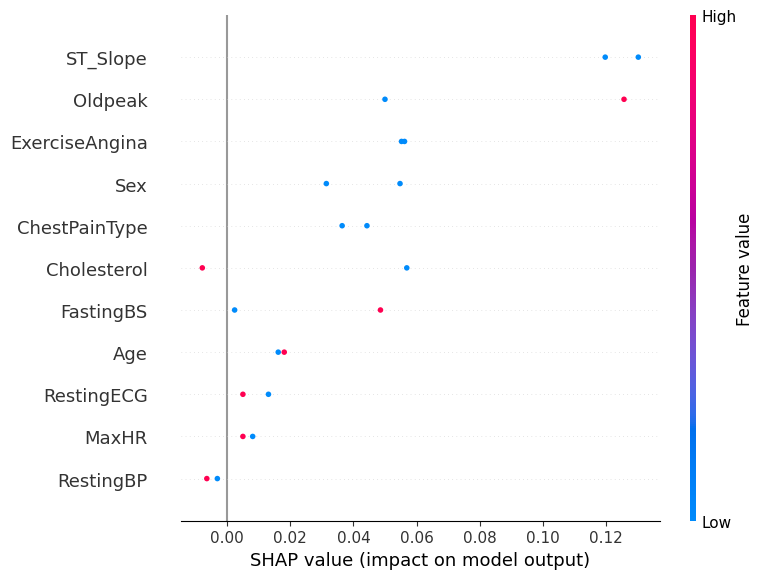

In [737]:
#Summary plot of the positive samples values. For all these plots on the x axis we have the impact
#Of the variable on the model output, a positive SHAP value means that that variable has a positive impact on the prediction (towards positive)
# On the other hand a negative value means that that variable has a negative impact (towards negative prediction)
shap.summary_plot(shap_values[positive_samples_index],X_test.iloc[positive_samples_index],feature_names=X_train.columns.values)

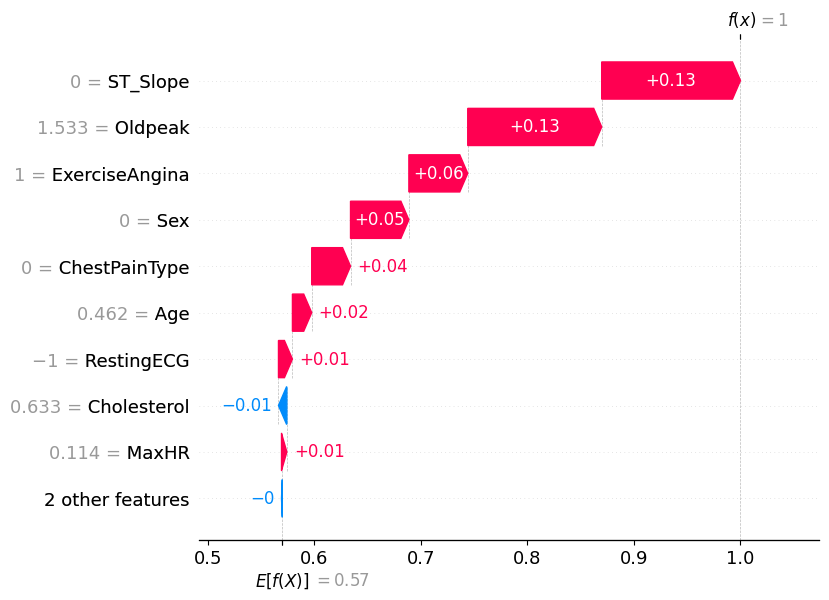

In [738]:
shap.plots.waterfall(shap_values[positive_samples_index[0]], max_display=10)

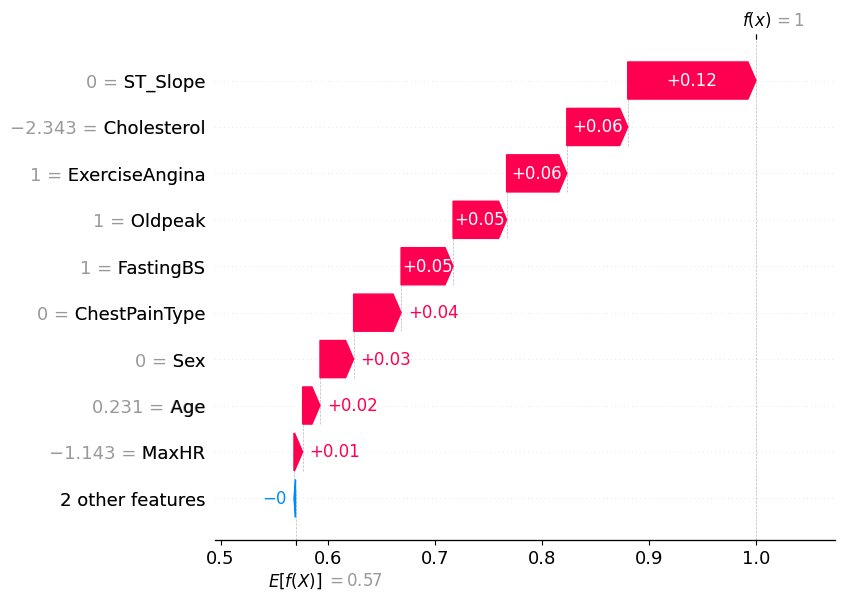

In [739]:
shap.plots.waterfall(shap_values[positive_samples_index[1]], max_display=10)

##### negative samples plots

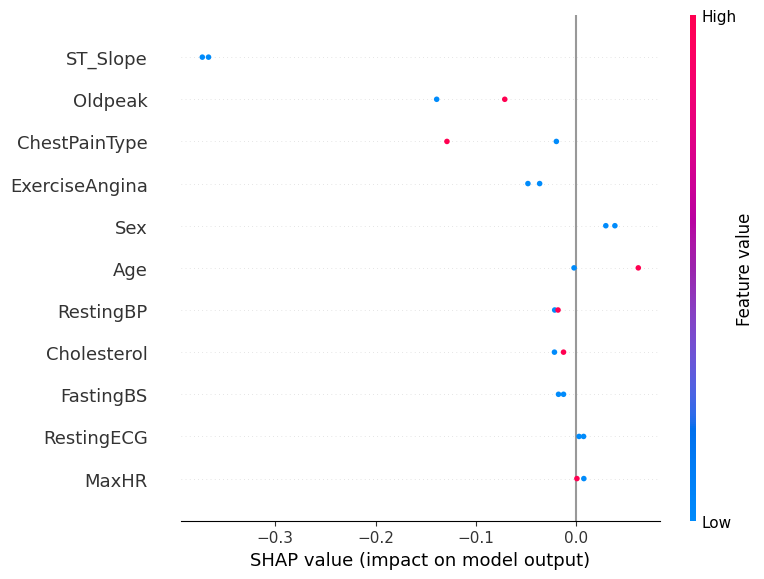

In [740]:
shap.summary_plot(shap_values[negative_samples_index],X_test.iloc[negative_samples_index],feature_names=X_train.columns.values)

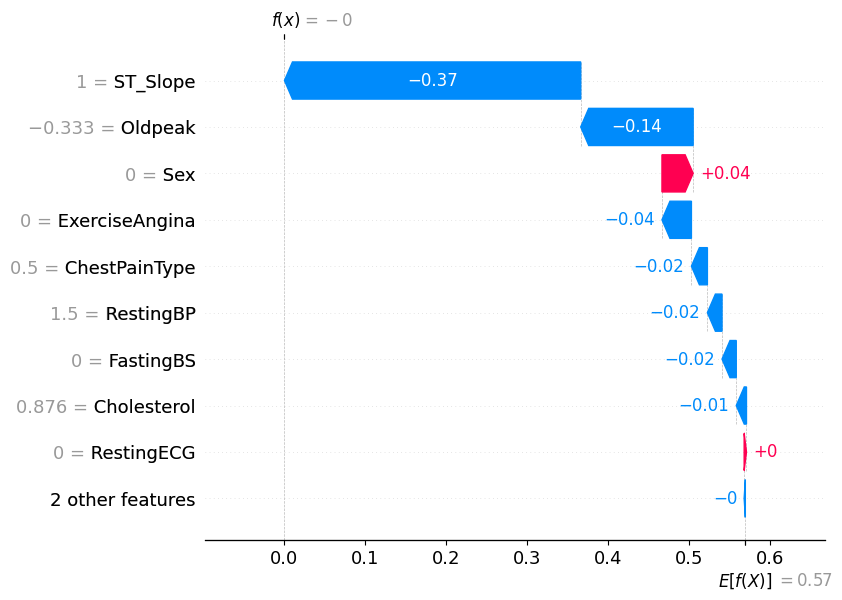

In [741]:
shap.plots.waterfall(shap_values[negative_samples_index[0]], max_display=10)

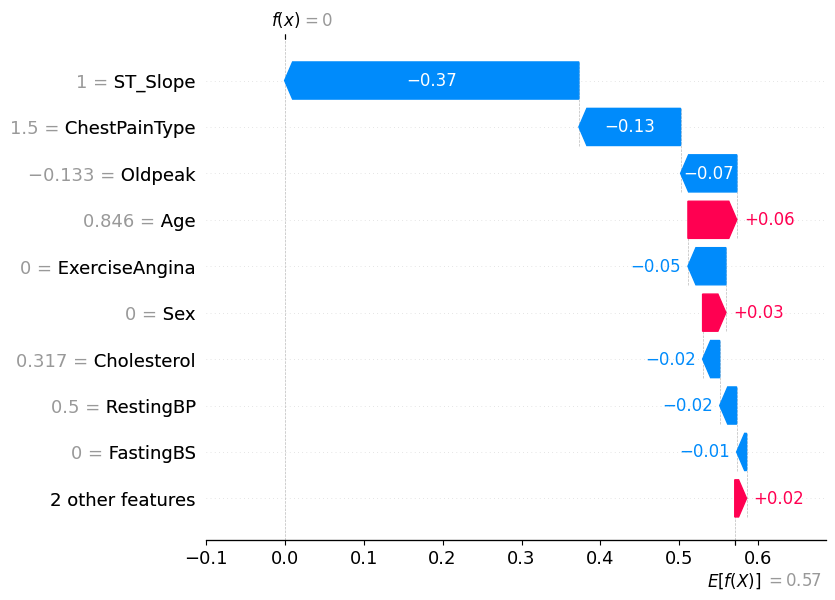

In [742]:
shap.plots.waterfall(shap_values[negative_samples_index[1]], max_display=10)

#### SHAP on all data

Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/184 [00:00<?, ?it/s]

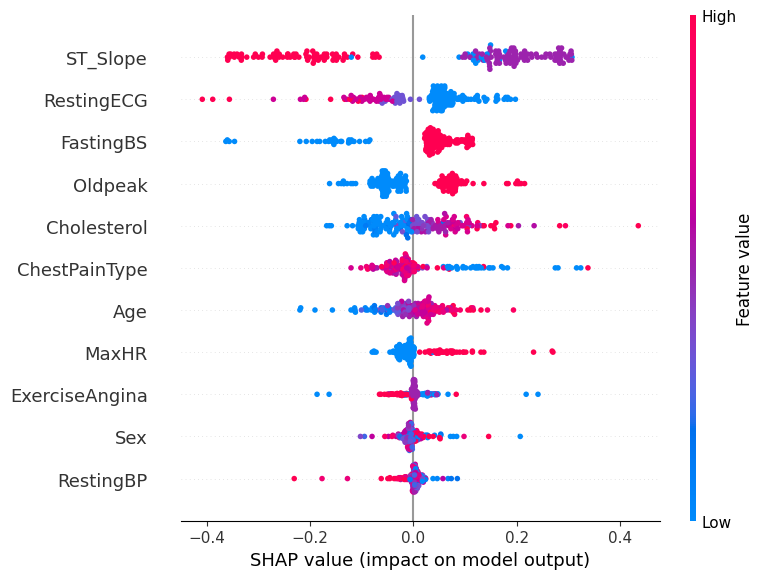

In [743]:
shap.summary_plot(shap_values,X_test,feature_names=df_train.columns.values)

## 4 - Q4 NAM

#### 4.1 - model

In [744]:
# 0 - SIMPLE VERSION
class NAM(nn.Module):
    def __init__(self, input_dim):
        super(NAM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 1 - df to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 2 - dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 3 - initialize
model = NAM(X_train.shape[1])


In [747]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1, 64)
        #self.l2 = nn.Linear(64, 128)
        self.l5 = nn.Linear(64, 64)
        self.l6 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        #x = F.relu(self.l2(x))
        x = F.relu(self.l5(x))
        out = self.l6(x)

        return out

class NAM(nn.Module):
    def __init__(self, num_features, link_func="sigmoid"):
        super().__init__()
        self.networks = nn.ModuleList([
            FeatureNetwork() for _ in range(num_features)
        ])
        self.num_features = num_features
        self.bias = nn.Parameter(torch.rand(1))
        self.link_func = link_func

    def forward(self, x):
        B, dim = x.shape
        outs = torch.Tensor(B, dim)
        
        for i in range(B):
            temp = torch.Tensor(dim)
            for j in range(self.num_features):
                net = self.networks[j]
                xi = x[i, j].unsqueeze(dim=0)
                temp[j] = net(xi)
            outs[i] = temp

        summed = outs.sum(axis=1) + self.bias

        if self.link_func == "sigmoid":
            res = torch.sigmoid(summed).view(B, 1)
        elif self.link_func == "tanh":
            res = torch.tanh(summed).view(B, 1)

        return res
# 1 - df to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 2 - dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 3 - initialize
model = NAM(X_train.shape[1])

I took away 2 layers and it seems better + simpler model performs better

#### 4.2 - training

In [746]:
# 0 - loss + optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# 1 - training
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# 2 - evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = torch.sigmoid(outputs)
    predicted_classes = (predictions >= 0.5).squeeze().cpu().numpy()
    accuracy = (predicted_classes == y_test).mean()
print(accuracy)

Epoch [10/150], Loss: 0.1406
Epoch [20/150], Loss: 0.0817
Epoch [30/150], Loss: 0.1201
Epoch [40/150], Loss: 0.0835
Epoch [50/150], Loss: 0.0276
Epoch [60/150], Loss: 0.0653
Epoch [70/150], Loss: 0.0744
Epoch [80/150], Loss: 0.1269
Epoch [90/150], Loss: 0.0631
Epoch [100/150], Loss: 0.0626
Epoch [110/150], Loss: 0.1378
Epoch [120/150], Loss: 0.0549
Epoch [130/150], Loss: 0.1337
Epoch [140/150], Loss: 0.0590
Epoch [150/150], Loss: 0.2317
0.5978260869565217
